# Evaluation metrics

Authors: Neha Sharma & Eva Yap, adapted by Karly Kussainova

In this notebook, you will evaluate your models to see how well they perform. After you finish this notebook, you will apply what you have learned here to your group project.

## What is the question we are trying to answer?

How good is the model we created?


### Accuracy
* One way to determine how well our model is performing is to look at its accuracy.
* Let's say we are given 100 images that we want to label as containing a car or not. If our classifies 90 of these images correctly, then we say that our model has an accuracy of 90%.
* There are other metrics used to evaluate how well our model is performing such as recall, precision, and F1. We will learn about them in this notebook!

## Recall data description

More information can be found [here](https://www.kaggle.com/competitions/titanic/data).

| Feature     | Description | Feature type  | Notes |
| ----------- | ----------- |----------- | ----------- |
| Survived    | Survival outcome | Categorical | 0 = No, 1 = Yes | 
| Pclass      | Ticket class | Categorical | 1 = 1st, 2 = 2nd, 3 = 3rd |
| Name        | Passenger name | Alphabetic | |
| Sex         | Sex | Categorical | |
| Age         | Age in years | Continuous | |
| SibSp       | # of siblings / spouses aboard the Titanic | Discrete | |
| Parch       | # of parents / children aboard the Titanic | Discrete | |
| Ticket      | Ticket number | Alphanumeric | |
| Fare        | Passenger fare | Continuous | |
| Cabin       | Cabin number | Alphanumeric | |
| Embarked    | Port of Embarkation | Categorical | C = Cherbourg, Q = Queenstown, S = Southampton |

Let's get started!

In [ ]:
# import pandas to create a data frame
import pandas as pd
import numpy as np

# import the libraries we'll use to create graphs
from matplotlib import pyplot as plt

# this command makes sure the graphs show in this window, not a new one
%matplotlib inline 

# import train and test CSV files as dataframes
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

## Data cleaning (done previously)

* In the previous exercises, we took a closer look at the Titanic dataset. 
* Some of the features are not useful for building a model and we will drop these features using the code below.
* Certain features contain missing values and we filled in the gaps using information we already have in the dataset (see Data Wrangling and Viz notebook). 
* We will also fill the missing values using the code below.

In [ ]:
# clean data to account for missing values and unnecessary information 
# see Data Wrangling and Viz notebook for more details

# drop Cabin
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

# drop Ticket
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

# map each Sex value to a numerical value
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

# replacing the missing values in the Embarked feature with S
train = train.fillna({"Embarked": "S"})
# map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

# fill in missing Fare value in test set based on mean fare for that Pclass 
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x] #Pclass = 3
        test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)
        
# map Fare values into groups of numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels = [1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels = [1, 2, 3, 4])
# drop Fare values
train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)

# Age feature
# sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

combine = [train, test]
# extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

# replace various titles with more common names
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

# map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

# fill missing age with mode age group for each title
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]
        
for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

# map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

# dropping the Age feature for now, might change
train = train.drop(['Age'], axis = 1)
test = test.drop(['Age'], axis = 1)

# drop Name
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Split the training set
We will use part of our training data (22% in this case) to evaluate our models.

In [ ]:
from sklearn.model_selection import train_test_split

predictors = train.drop(['Survived', 'PassengerId'], axis=1)
target = train["Survived"]
x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.22, random_state = 0)

## Choose a classification model

We will evaluate the decision trees model we build in a previous notebook.



In [ ]:
# decision trees
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_test)
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ' + str(accuracy ))


acc_decisiontree = round(accuracy_score(y_pred, y_test) * 100, 2)
print('Accuracy after normalizing it: ' + str(acc_decisiontree ))


Accuracy: 0.8121827411167513
Accuracy after normalizing it: 81.22


## Confusion matrix
* First, we will look at the confusion matrix.
* This array of numbers shows us the accurate predictions (i.e. true positive and true negative) and incorrect predictions (i.e. false positive and false negative). 

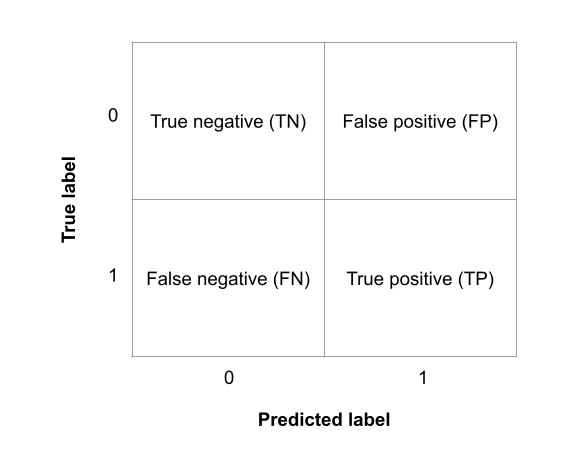

In [ ]:
# print confusion matrix for the model we want to evaluate
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[109,  15],
       [ 22,  51]])

This isn't super useful, since there are no labels. Let's try making this into a diagram that is more useable.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


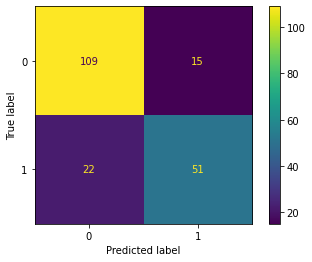

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(decisiontree,x_test, y_test)

Much better! Now we can use the labels to see where the true label (from our dataset) and the predicted label (from our decision tree model) are the same and where they are different.

## Accuracy, Recall, Precision, and F1 ##

### Accuracy
* How often is the classifier correct? 
* Calculated by (total number of observations correctly predicted) divided by (total number of observations).

### Recall
* Also called true positive rate or sensitivity 
* For each row in the confusion matrix (true labels 0 and 1) a recall value is calculated.
* This value is (number  of observations correctly predicted in that row) divided by true total number in that row.
* The **true total** is what you get by adding up the values across a row. 
* For example, for label 1, recall is (52)/(21+52)

### Precision
* Precision is calculated by column in the confusion matrix above. 
* For each column (predicted labels 0 and 1), a precision value is calculated. 
* This is calculated by (number of observations correctly predicted in that column) divided by the total predicted in that column. 
* For example, for the column of predicted values of 1, precision is (52)/(14+52)


### F1
This score combines the recall and precision values (it is a weighted average).

For another description of each of these terms see [this article](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

In [ ]:
# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print('Accuracy: ', acc)

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print('Recall: ', recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precision: ', precision)

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print('F1 score: ', f1_score)

Accuracy:  0.8121827411167513
Recall:  0.6986301369863014
Precision:  0.7727272727272727
F1 score:  0.7338129496402879


## Use the `classification_report` function

* To see all of this easily in one place, you can use the `classification_report` function
* At the top, precision, recall, and the F1 score are broken out by the level that we're predicting (0 and 1). At the bottom of the report, we have accuracy, the macro-averaged precision, recall, and F1 score, and the weighted average precision, recall, and F1 score.
* **Macro** weighting means there aren't weights when you combine the scores together, so when we combine all of the precision scores, for example, we are adding the scores for 0 and 1.
* The **weighted average** combines all of the scores, but gives them weights for how many observations were in that class.
* The **support** is the number of actual occurrences of the class in the specified dataset

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits = 2))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       124
           1       0.77      0.70      0.73        73

    accuracy                           0.81       197
   macro avg       0.80      0.79      0.79       197
weighted avg       0.81      0.81      0.81       197



## Practice question 1
Apply another classification technique. Create a confusion matrix and run a classification report. 

84.26
              precision    recall  f1-score   support

           0      0.884     0.863     0.873       124
           1      0.776     0.808     0.792        73

    accuracy                          0.843       197
   macro avg      0.830     0.836     0.833       197
weighted avg      0.844     0.843     0.843       197



/Users/karlykussainova/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


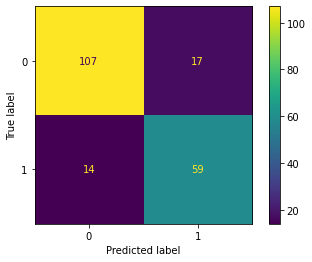

In [ ]:
# write code for question 1 below

# random forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_test)
acc_randomforest = round(accuracy_score(y_pred, y_test) * 100, 2)
print(acc_randomforest)

# confusion matrix
plot_confusion_matrix(randomforest,x_test, y_test)

# print the classification report
print(classification_report(y_test,y_pred, digits = 3))

## Practice question 2
How do you know this model is better (or not) than the first decision tree in this notebook?

Write your question 2 answer here

In the example, the weighted average score and macro average scores are slightly higher, indicating better model performance.

In [ ]:
Answer key

[1] 
0.22


[2]
DecisionTreeClassifier()


[3], [4]
(x_train, y_train)


[5]
y_test


[6]
decisiontree


# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)
print('Recall: ', recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precision: ', precision)

from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred)
print('F1 score: ', f1_score)